In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import econml
import importlib
import pyreadr

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")
np.random.seed(0)

In [224]:
outcome_cols = ["opioiduse12", "opioiduse24"]
treatment_col = "medicine_assigned"
discrete_cov = ["xrace", "mar", "sex"]

baseline_harmonized = pd.read_csv(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/updated_data/ctn0094/drv/clean_patients_with_relapse_wide.csv",
    index_col=0,
)

# baseline_harmonized = baseline_harmonized.rename(
#     columns={col: col.split(".")[1] for col in baseline_harmonized.columns}
# ).set_index("who")

stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )
df = stacked_list[0]

df_tedsa = df.loc[df["trialdata"] == 0]

In [225]:
pd.get_dummies(baseline_harmonized, columns=[treatment_col] + discrete_cov).groupby(
    by=["project"]
).mean()

,age,hcows,edu,hwithdraw,alcdisorder,cocdisorder,hasBrainDamage,hasEpilepsy,hasSchiz,hasBipolar,...,medicine_assigned_nal,xrace_1,xrace_2,xrace_3,xrace_4,mar_1.0,mar_2.0,mar_3.0,sex_female,sex_male
project,,,,,,,,,,,,,,,,,,,,,
27,36.881196,12.789223,2.085890,2.473059,0.212903,0.323102,0.091483,0.031471,0.025217,0.115748,...,0.000000,0.675846,0.085759,0.162077,0.076318,0.020456,0.037766,0.069237,0.322581,0.677419
30,32.058333,13.041899,2.227778,2.469274,0.108333,0.077778,0.175000,0.025000,0.002793,0.058496,...,0.000000,0.886111,0.022222,0.050000,0.041667,0.283333,0.213889,0.500000,0.419444,0.580556
51,33.857895,16.677193,2.168421,2.877193,0.278947,0.307018,0.121053,0.085965,0.012281,0.138596,...,0.496491,0.652632,0.094737,0.173684,0.078947,0.096491,0.215789,0.687719,0.296491,0.703509


## TEDS-A vs CTN 27

In [140]:
ct94 = baseline_harmonized.loc[(baseline_harmonized["project"] == 27)]
ct94["PREG"] = 0
outcome94 = ct94[outcome_cols]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

df_tedsa_cc = df_tedsa[common_cols]
df_tedsa_cc["S"] = 0
ct94_cc = ct94[common_cols].fillna(0)
ct94_cc["med_met"] = (
    (ct94[treatment_col] == "met").astype(int).fillna(0)
)  # methadone = 1 and bupenorphine = 0
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0

# invert age categories
df_tedsa_cc["age"].replace(
    {
        1: 13,
        2: 16,
        3: 18,
        4: 22,
        5: 27,
        6: 32,
        7: 37,
        8: 42,
        9: 47,
        10: 52,
        11: 60,
        12: 68,
    },
    inplace=True,
)

ct94_cc["S"] = 1
ct94_cc = ct94_cc.astype(int)

ct94_cc = ct94_cc.join(outcome94, how="inner")

ct94_cc.groupby(by="med_met").mean()[outcome_cols]

,opioiduse12,opioiduse24
med_met,,
0,0.629380,0.750674
1,0.553875,0.650284


In [141]:
print(
    (
        ct94_cc.loc[ct94_cc["med_met"] == 1, outcome_cols[1]].mean()
        - ct94_cc.loc[ct94_cc["med_met"] == 0, outcome_cols[1]].mean(),
        1.96
        * np.sqrt(
            ct94_cc.loc[ct94_cc["med_met"] == 1, outcome_cols[1]].var()
            / ct94_cc.loc[ct94_cc["med_met"] == 1, outcome_cols[1]].shape[0]
            + ct94_cc.loc[ct94_cc["med_met"] == 0, outcome_cols[1]].var()
            / ct94_cc.loc[ct94_cc["med_met"] == 0, outcome_cols[1]].shape[0]
        ),
    )
)

(-0.1003903005722031, 0.05123408063788226)


In [170]:
df_primary = pd.concat([df_tedsa_cc, ct94_cc])

df_ = df_primary.drop(columns=[outcome_cols[0]]).fillna(0)

outcome = outcome_cols[1]
treatment = "med_met"
sample = "S"
data = df_
S = df_[sample]  # indicator for the sample
Y = df_[outcome]  # outcome variable
T = df_[treatment]  # indicator for the treatment

data_dummy = pd.get_dummies(data, columns=["xrace", "mar"])
data_dummy["edu_12y"] = (data_dummy["edu"] >= 2).astype(int)
data_dummy.drop(columns=["edu", "mar_0"], inplace=True)

X = data_dummy.drop(columns=[outcome, treatment, sample])  # pre-treatment covariates

In [177]:
importlib.reload(learn)
df_v, pi, pi_m, mu_1_m, mu_0_m, e_m, data2 = learn.estimate_dml(
    data_dummy, outcome, treatment, sample, crossfit=10
)

print(df_v.join(S).groupby(by="S").mean())

         te     te_sq
S                    
0 -0.115462  0.056102
1 -0.036391  4.260135


In [178]:
importlib.reload(learn)
# D, w_tree, testing_data = learn.tree_opt(data, outcome, treatment, sample, leaf_proba=1)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=data_dummy,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
    leaf_proba=1,
    num_trees=3500,
    vote_threshold=1 / 4,
    top_k_trees=True,
    k=50,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
optimized_loss_forest = np.sqrt(
    np.sum(D_rash["vsq"] * D_rash["w_opt"]) / ((np.sum(D_rash["w_opt"])) ** 2)
)
print("Baseline Objective:%.4f" % (baseline_loss))
print("Optimized Objective (Forest):%.4f" % (optimized_loss_forest))

ATE Est: -0.1018
leaf                   0.500000
ivdrug                 0.008414
sex                    0.012423
age                    0.000252
bcannabis30_base       0.018138
bbenzo30_base          0.013397
PREG                   0.001966
bamphetamine30_base    0.011893
xrace_1                0.038592
xrace_2                0.007745
xrace_3                0.032314
xrace_4                0.014023
mar_1                  0.107206
mar_2                  0.136081
mar_3                  0.072264
edu_12y                0.025291
dtype: float64
Baseline Objective:0.0003
Optimized Objective (Forest):0.0003


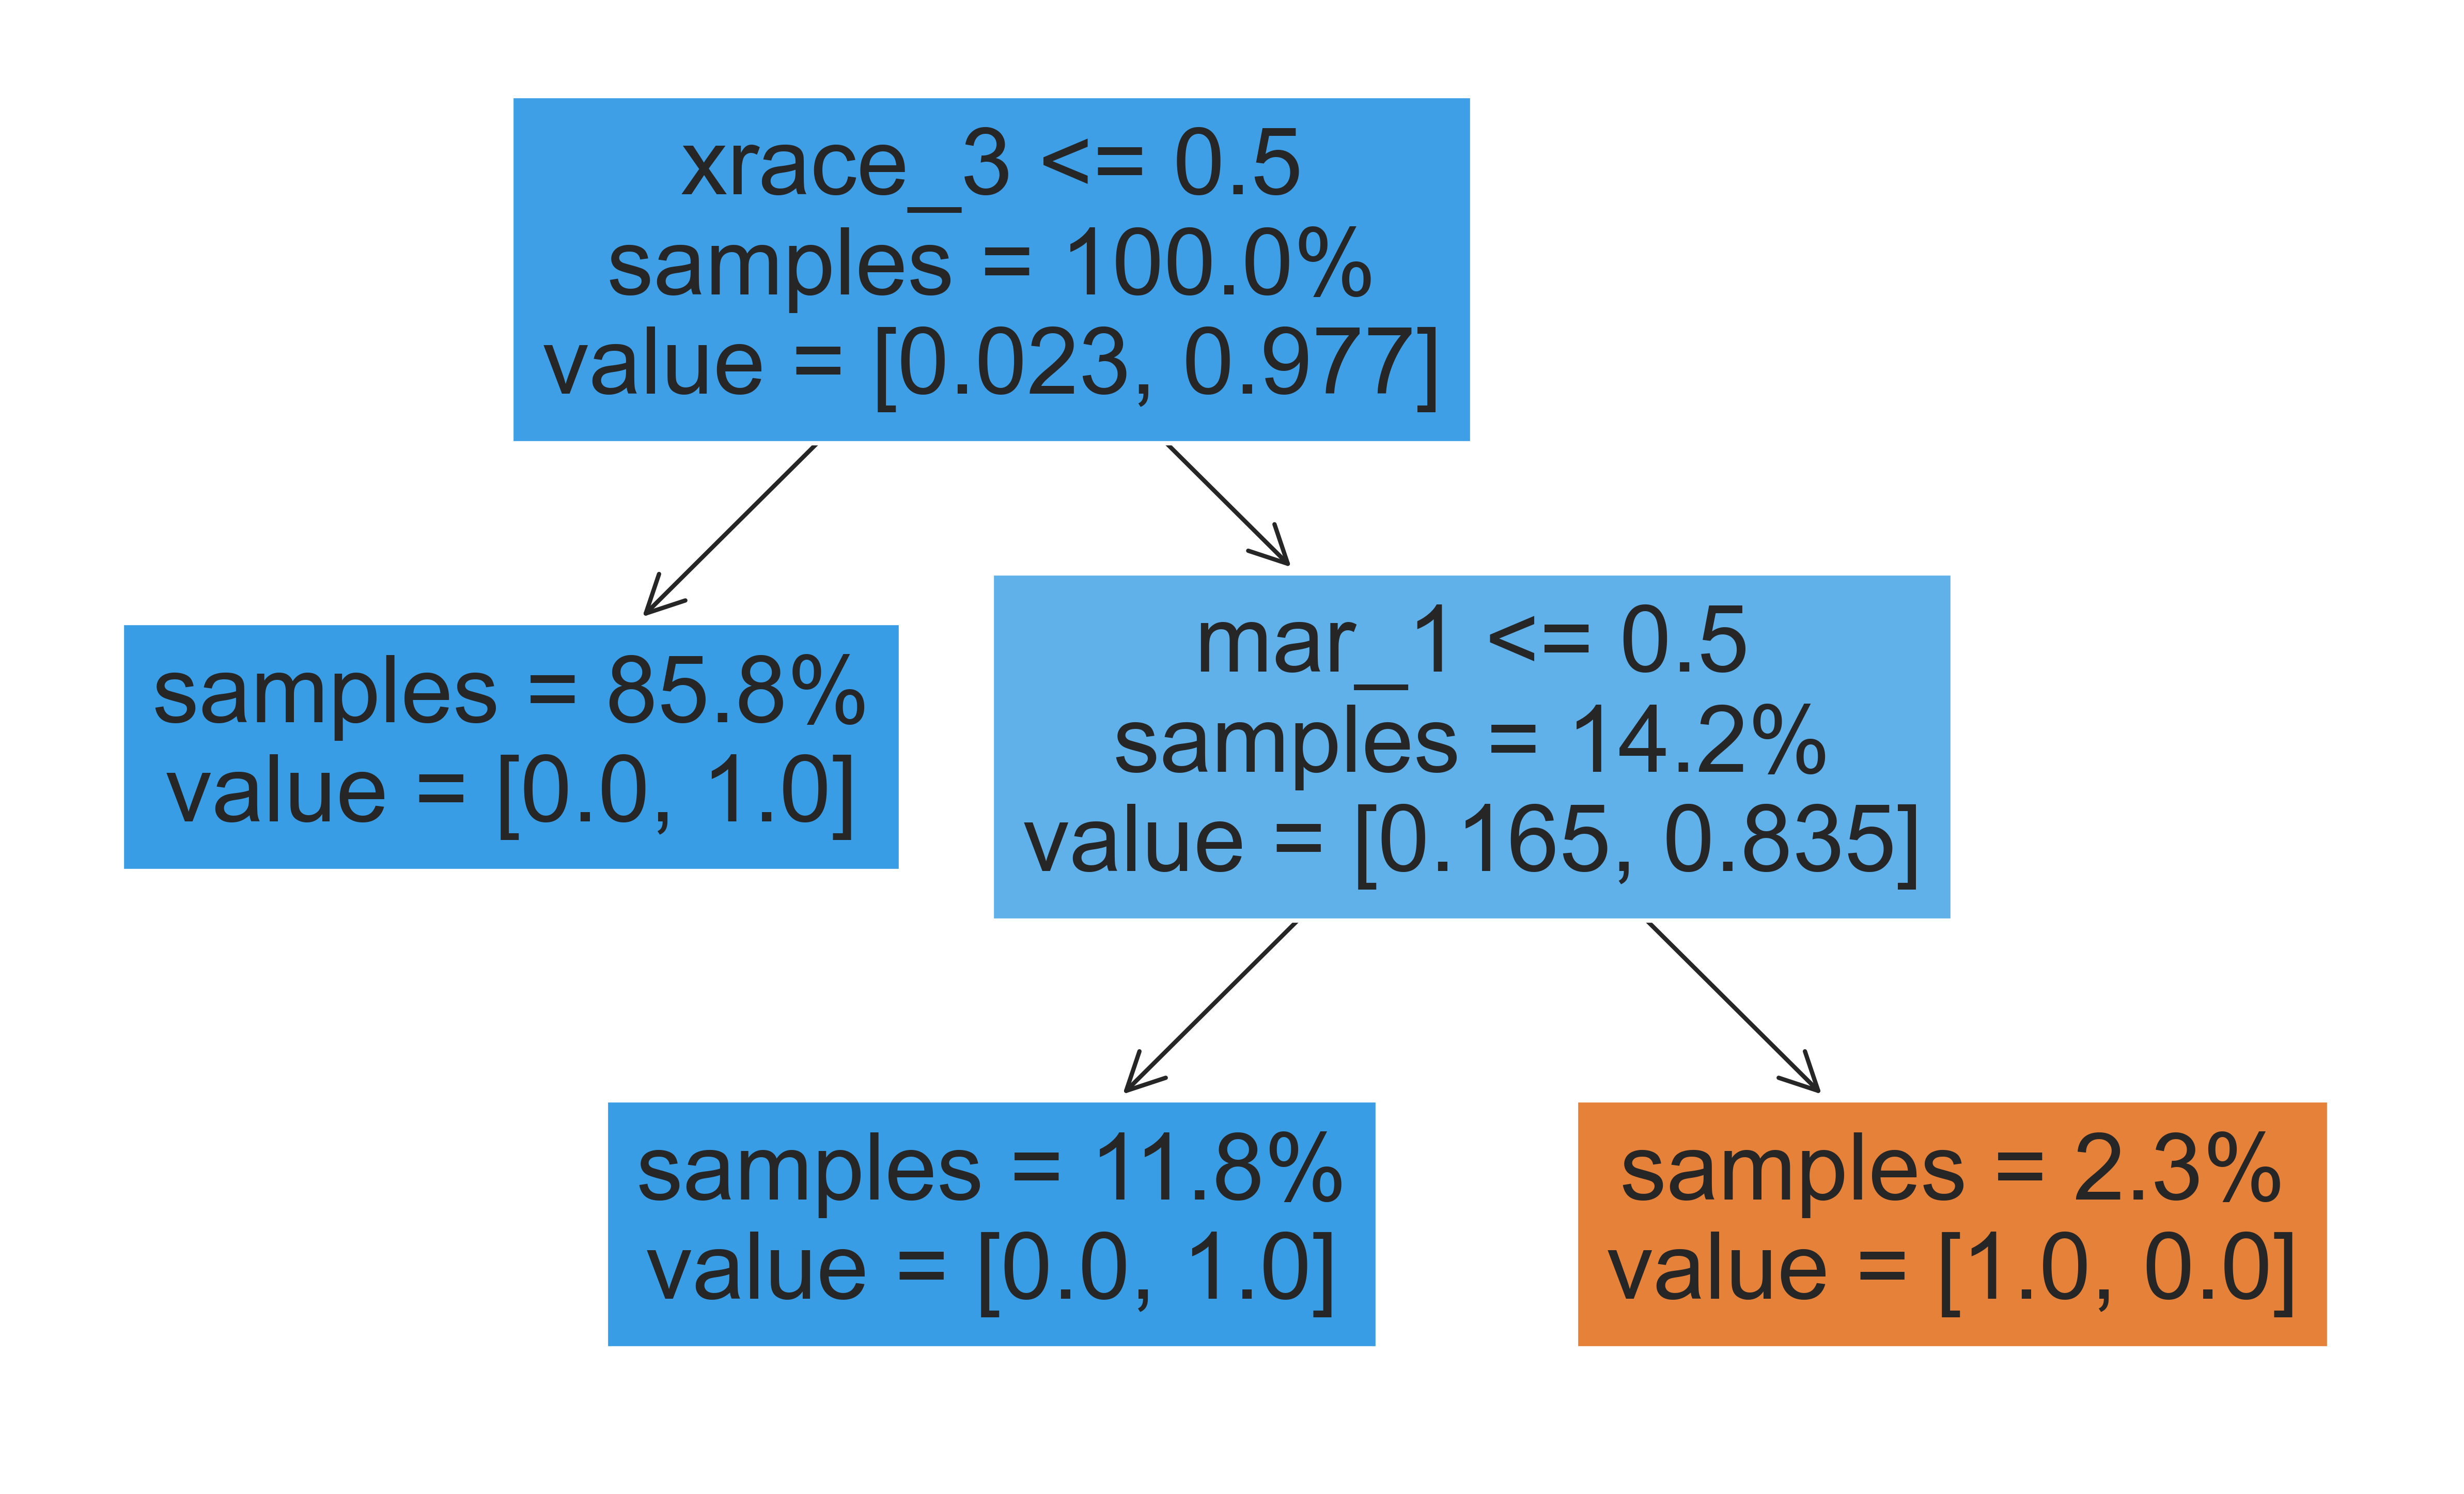

In [180]:
sns.set(font_scale=1)
fig, ax = plt.subplots(ncols=1, figsize=(10, 6), sharex=True, sharey=True, dpi=600)
tree.plot_tree(
    f,
    ax=ax,
    feature_names=data_dummy.drop(columns=[outcome, sample, treatment]).columns,
    filled=True,
    proportion=True,
    impurity=False,
)
plt.savefig("tedsa_ctn27_.pdf")

In [223]:
print(
    r"Pre Pruning, SATE: %.5f ± %.5f"
    % (
        df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].mean()
        - df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].mean(),
        1.96
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].sem()
            + df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].sem()
        ),
    )
)

print(
    r"Pre Pruning, ATTE: %.5f ± %.5f"
    % (
        D_rash["v"].mean(),
        1.96 * np.sqrt(D_rash["vsq"].mean() / D_rash["w_opt"].count()),
    )
)

print(
    r"Post Pruning, ATTE: %.5f ± %.5f"
    % (
        D_rash["v"].loc[D_rash["w_opt"] == 1].mean(),
        1.96
        * np.sqrt(
            D_rash["vsq"].loc[D_rash["w_opt"] == 1].mean() / D_rash["w_opt"].sum()
        ),
    )
)

Pre Pruning, SATE: -0.10039 ± 0.07183
Pre Pruning, ATTE: -0.10181 ± 0.00069
Post Pruning, ATTE: -0.11146 ± 0.00068


In [220]:
w_rash = [
    "w_tree_%d" % (i)
    for i in range(len(w_forest))
    if w_forest[i]["local objective"] < baseline_loss
]

avg_votes = (D_forest[w_rash].mean(axis=1) < 0.5).astype(int)

explainer = en.AdaBoostRegressor().fit(X.loc[avg_votes.index], avg_votes)

In [221]:
len(explainer.estimators_)

1

TypeError: 'Axes' object is not subscriptable

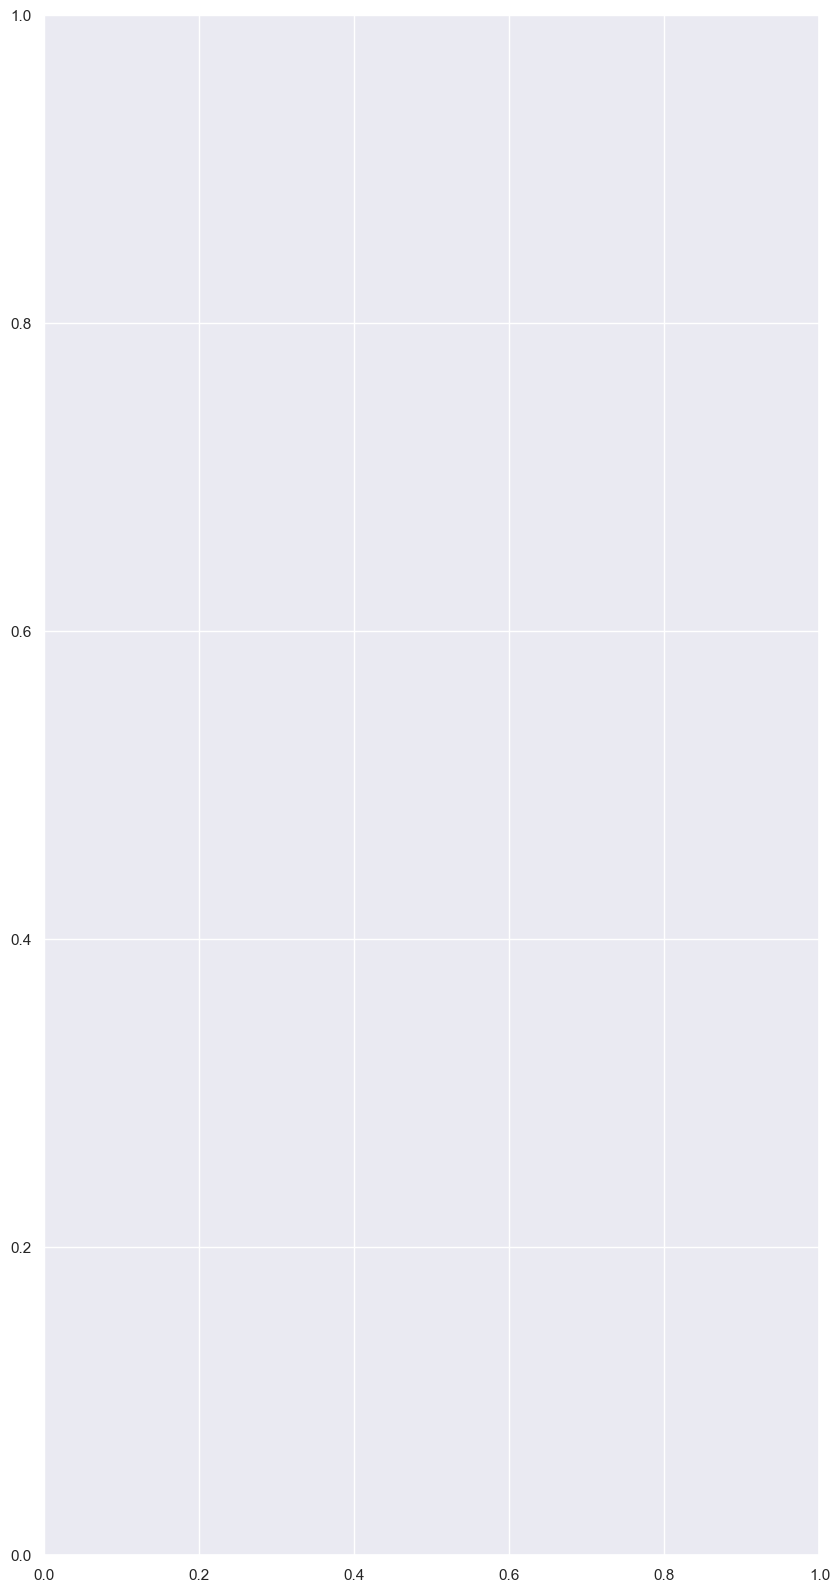

In [222]:
num_trees = min(5, len(explainer.estimators_))
fig, ax = plt.subplots(nrows=num_trees, figsize=(10, 20))
for i in range(num_trees):
    tree.plot_tree(
        explainer.estimators_[i],
        feature_names=X.columns,
        ax=ax[i],
        filled=True,
        fontsize=10,
        # proportion=True,
    )
plt.savefig("tedsa_ctn27_2.pdf")

Thoughts:
* TEDSA (observational data) has fewer covariates than experimental sample. Maybe there is different and interesting question here?

# TEDS-A vs CTN 51

In [ ]:
outcome_cols = ["wk%d.relapse_this_week" % (i) for i in range(1, 11)]
outcome94 = relapse_harmonized_wide.loc[
    # (relapse_harmonized_wide["project"] == "27")
    # + (relapse_harmonized_wide["project"] == "30") +
    (relapse_harmonized_wide["project"] == "51")
][outcome_cols]

ct94 = baseline_harmonized.loc[
    # (baseline_harmonized["project"] == "27")
    # + (baseline_harmonized["project"] == "30") +
    (baseline_harmonized["project"] == "51")
]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

df_tedsa_cc = df_tedsa[common_cols]
df_tedsa_cc["S"] = 0
ct94_cc = ct94[common_cols].fillna(0)
ct94_cc["med_nal"] = (
    (ct94["medicine"] == "nal").astype(int).fillna(0)
)  # methadone = 1 and bupenorphine = 0
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0

# Create age categories
ct94_cc["age1"] = 0
ct94_cc.loc[ct94_cc["age"] < 15, "age1"] = 1
ct94_cc.loc[(ct94_cc["age"] > 14) & (ct94_cc["age"] < 18), "age1"] = 2
ct94_cc.loc[(ct94_cc["age"] > 17) & (ct94_cc["age"] < 21), "age1"] = 3
ct94_cc.loc[(ct94_cc["age"] > 20) & (ct94_cc["age"] < 25), "age1"] = 4
ct94_cc.loc[(ct94_cc["age"] > 24) & (ct94_cc["age"] < 30), "age1"] = 5
ct94_cc.loc[(ct94_cc["age"] > 29) & (ct94_cc["age"] < 35), "age1"] = 6
ct94_cc.loc[(ct94_cc["age"] > 34) & (ct94_cc["age"] < 40), "age1"] = 7
ct94_cc.loc[(ct94_cc["age"] > 39) & (ct94_cc["age"] < 45), "age1"] = 8
ct94_cc.loc[(ct94_cc["age"] > 44) & (ct94_cc["age"] < 50), "age1"] = 9
ct94_cc.loc[(ct94_cc["age"] > 49) & (ct94_cc["age"] < 55), "age1"] = 10
ct94_cc.loc[(ct94_cc["age"] > 54) & (ct94_cc["age"] < 65), "age1"] = 11
ct94_cc.loc[ct94_cc["age"] > 64, "age1"] = 12

# Assign the 'age1' values to 'age' column
ct94_cc["age"] = ct94_cc["age1"]

# Optionally, you can drop the 'age1' column if you no longer need it
ct94_cc.drop(columns=["age1"], inplace=True)
ct94_cc["S"] = 1
ct94_cc = ct94_cc.astype(int)

# ct94_cc = ct94_cc.join(outcome94, how="inner")

# fig, ax = plt.subplots(figsize=(20, 4))
# ct94_cc.groupby(by="med_nal").mean()[outcome_cols].diff().T[1].plot(kind="line", ax=ax)
# plt.axhline(0, c="black")